In [1]:
import graphlab as gl
import pandas as pd
import numpy as np
import scipy.stats.stats as stats
#%load_ext rpy2.ipython
import itertools
from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics, preprocessing, datasets   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Performing grid search
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import LabelKFold
from sklearn.cross_validation import LeaveOneLabelOut
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 8
import sys
import pickle
from graphlab.util import cloudpickle
import graphlab.aggregate as agg
from math import sqrt

/net/gs/vol3/software/modules-sw-python/2.7.3/requests/2.7/Linux/RHEL6/x86_64/lib/python2.7/site-packages/requests-2.7.0-py2.7.egg/requests/packages/urllib3/util/ssl_.py:90: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning


This non-commercial license of GraphLab Create for academic use is assigned to vegray@uw.edu and will expire on June 06, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1502472612.log


In [2]:
# Load the data
data =  gl.SFrame.read_csv('/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/data/dmsTraining_2017-02-20.csv')

Finished parsing file /net/fowler/vol1/home/vegray/metaDMS/dato/scaled/data/dmsTraining_2017-02-20.csv

Parsing completed. Parsed 100 lines in 2.40807 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,str,str,str,int,int,str,str,str,str,str,float,str,str,str,str,int,str,str,str,str,str,float,float,float,int,int,int,float,float,float,int,float,float,float,float,str,str,float,float,float,str,float,float,float,float,int,float,str,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /net/fowler/vol1/home/vegray/metaDMS/dato/scaled/data/dmsTraining_2017-02-20.csv

Parsing completed. Parsed 101460 lines in 1.25598 secs.

In [3]:
## Use predictors3
predictors3 = ['aa1', 'aa2', 'wt_mut', 'aa1_polarity', 
               'aa2_polarity', 'aa1_PI', 'aa2_PI', 'deltaPI', 
               'Grantham', 'aa1_weight', 'aa2_weight', 'deltaWeight',
               'aa1vol', 'aa2vol', 'deltavolume', 'aa1_psic',
               'aa2_psic', 'delta_psic',  'accessibility',
               'dssp_sec_str', 'phi_psi_reg', 'delta_solvent_accessibility',
               'b_factor', 'mut_msa_congruency', 'mut_mut_msa_congruency', 
               'seq_ind_closest_mut',  'evolutionary_coupling_avg']

In [4]:
## Global model dataset cleanup
data2 = data.filter_by([x for x in data['dms_id'].unique() if x not in ['CcdB','beta-lactamase_2500', 'beta-lactamase_0', 
                                                                                      'kka2_1:1','kka2_1:4','kka2_1:8',
                                                                     'beta-lactamase_39', 'gal4','hemagglutinin', 'np',
                                                                                      'dbr1', 'beta-lactamase_156',
                                                                                      'beta-lactamase_625', 'ERK2','GFP',
                                                                                      'Brca1_HDR', ]], 'dms_id')
#data2 = data2[(data2['binary_mut_type_prob'] < 0.4) | (data2['binary_mut_type_prob'] > 0.6)]
data2 = data2.filter_by([x for x in data2['mut_type'].unique() if x in ['missense']], 'mut_type')
#del data2['id']
#data2 = data2.add_row_number('id',0)

In [5]:
len(data2['dms_id'])
data2.to_dataframe().groupby(['dms_id','position']).count()

id3  variant_id  first_author  protein  id  snap2score  \
dms_id   position                                                           
Brca1_E3 2          13          13            13       13  13           0   
         3          18          18            18       18  18           0   
         4          18          18            18       18  18           0   
         5          19          19            19       19  19           0   
         6          19          19            19       19  19           0   
         7          19          19            19       19  19           0   
         8          19          19            19       19  19           0   
         9          19          19            19       19  19           0   
         10         19          19            19       19  19           0   
         11         19          19            19       19  19           0   
         12         17          17            17       17  17           0   
         13         15          15            15       15  15           0   
         14         13          13            13       13  13           0   
         15         18          18            18       18  18           0   
         16         19          19            19       19  19           0   
         17         19          19            19       19  19           0   
         18         19          19            19       19  19           0   
         19         19          19            19       19  19           0   
         20         19          19            19       19  19           0   
         21         19          19            19       19  19           0   
         22         19          19            19       19  19           0   
         23         19          19            19       19  19           0   
         24         19          19            19       19  19           0   
         25         18          18            18       18  18           0   
         26         19          19            19       19  19           0   
         27         19          19            19       19  19           0   
         28         19          19            19       19  19           0   
         29         19          19            19       19  19           0   
         30         19          19            19       19  19           0   
         31         19          19            19       19  19           0   
...                ...         ...           ...      ...  ..         ...   
kka2_1:2 235        19          19            19       19  19          19   
         236        23          23            23       23  23          23   
         237        20          20            20       20  20          20   
         238        18          18            18       18  18          18   
         239        23          23            23       23  23          23   
         240        21          21            21       21  21          21   
         241        21          21            21       21  21          21   
         242        21          21            21       21  21          21   
         243        21          21            21       21  21          21   
         244        23          23            23       23  23          23   
         245        22          22            22       22  22          22   
         246        18          18            18       18  18          18   
         247        22          22            22       22  22          22   
         248        14          14            14       14  14          14   
         249        17          17            17       17  17          17   
         250        24          24            24       24  24          24   
         251        21          21            21       21  21          21   
         252        20          20            20       20  20          20   
         253        24          24            24       24  24          24   
         254   

## Kka2 

In [6]:
NOKka2_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['Kka2']], 'protein')
NOKka2_data2 = NOKka2_data.filter_by([x for x in NOKka2_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOKka2_data2['id']
NOKka2_data2 = NOKka2_data2.add_row_number('id',0)

folds = gl.cross_validation.KFold(NOKka2_data2,10)

In [15]:
params = dict([('target', 'scaled_effect1'), ('max_depth', 5), ('max_iterations' , [10,25,50,100,250]), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , 1), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

params1 = dict([('target', 'scaled_effect1'), ('max_depth', [2, 6, 10, 25, 50] ), ('max_iterations' , 50), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , [2, 6, 10, 25, 50]), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

params2 = dict([('target', 'scaled_effect1'), ('max_depth',6), ('max_iterations' , 50), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' ,2 ), 
               ('min_loss_reduction' , [0, 0.1, 0.2, 0.3, 0.4, 0.5]), ('step_size' , 0.1), ('features' , [predictors3])])

params3 = dict([('target', 'scaled_effect1'), ('max_depth',6), ('max_iterations' , 50), 
               ('column_subsample' , [0.6, 0.7, 0.8, 0.9]), ('row_subsample' , [0.6, 0.7, 0.8, 0.9]), ('min_child_weight' ,2 ), 
               ('min_loss_reduction' ,  0.5), ('step_size' , 0.1), ('features' , [predictors3])])

In [16]:
lopo_output_protein_Kka2_1 = gl.model_parameter_search.grid_search.create(folds, gl.boosted_trees_regression.create, params3)   


[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-09-2017-16-49-1100000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-09-2017-16-49-1100000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Aug-09-2017-16-49-1100000' already exists. Renaming the job to 'Model-Parameter-Search-Aug-09-2017-16-49-1100000-60493'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-09-2017-16-49-1100000-60493' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-09-2017-16-49-1100000-60493' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-09-2017-16-49-1100001' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-09-2017-16-49

In [17]:
lopo_output_protein_Kka2_1.get_best_params()

{'column_subsample': 0.6,
 'features': ['aa1',
  'aa2',
  'wt_mut',
  'aa1_polarity',
  'aa2_polarity',
  'aa1_PI',
  'aa2_PI',
  'deltaPI',
  'Grantham',
  'aa1_weight',
  'aa2_weight',
  'deltaWeight',
  'aa1vol',
  'aa2vol',
  'deltavolume',
  'aa1_psic',
  'aa2_psic',
  'delta_psic',
  'accessibility',
  'dssp_sec_str',
  'phi_psi_reg',
  'delta_solvent_accessibility',
  'b_factor',
  'mut_msa_congruency',
  'mut_mut_msa_congruency',
  'seq_ind_closest_mut',
  'evolutionary_coupling_avg'],
 'max_depth': 6,
 'max_iterations': 50,
 'min_child_weight': 2,
 'min_loss_reduction': 0.5,
 'row_subsample': 0.9,
 'step_size': 0.1,
 'target': 'scaled_effect1'}

In [18]:
## Kka2
NOKka2_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['Kka2']], 'protein')
NOKka2_data2 = NOKka2_data.filter_by([x for x in NOKka2_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOKka2_data2['id']
NOKka2_data2 = NOKka2_data2.add_row_number('id',0)

NoKka2_model = gl.boosted_trees_regression.create(NOKka2_data2, 'scaled_effect1', features = predictors3, max_iterations = 250,
                                                   column_subsample = 0.6, row_subsample = 0.9,
                                                           min_child_weight = 2, min_loss_reduction = 0.5, step_size = 0.01, max_depth = 6)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees regression:

--------------------------------------------------------

Number of examples          : 22086

Number of features          : 27

Number of unpacked features : 27

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 0.127471     | 1.163836           | 0.777921             | 0.419828      | 0.417101        |

| 2         | 0.266623     | 1.159854           | 0.773387             | 0.417019      | 0.414331        |

| 3         | 0.413822     | 1.155633           | 0.768946             | 0.414129      | 0.411494        |

| 4         | 0.537577     | 1.151129           | 0.764657             | 0.411276      | 0.408687        |

| 5         | 0.680695     | 1.147390           | 0.760793             | 0.408505      | 0.405962        |

| 6         | 0.807237     | 1.143425           | 0.756646             | 0.405734      | 0.403236        |

| 10        | 1.287899     | 1.128617           | 0.741392             | 0.395457      | 0.393052        |

| 11        | 1.398407     | 1.125047           | 0.737891             | 0.392891      | 0.390532        |

| 20        | 2.284962     | 1.091515           | 0.706199             | 0.371472      | 0.369356        |

| 30        | 3.121717     | 1.058413           | 0.672930             | 0.350286      | 0.348619        |

| 40        | 3.831369     | 1.028977           | 0.643368             | 0.331492      | 0.330294        |

| 50        | 4.416192     | 1.001739           | 0.655791             | 0.315504      | 0.314681        |

| 51        | 4.475082     | 0.998766           | 0.658115             | 0.314024      | 0.313229        |

| 60        | 4.974685     | 1.002936           | 0.680322             | 0.301705      | 0.301161        |

| 70        | 5.472614     | 1.023131           | 0.693244             | 0.289108      | 0.288952        |

| 80        | 5.906805     | 1.038177           | 0.709449             | 0.278030      | 0.278361        |

| 90        | 6.325122     | 1.047810           | 0.727077             | 0.268568      | 0.269349        |

| 100       | 6.738158     | 1.060936           | 0.743081             | 0.260282      | 0.261494        |

| 101       | 6.779455     | 1.062123           | 0.744268             | 0.259549      | 0.260786        |

| 110       | 7.159047     | 1.068625           | 0.754633             | 0.252954      | 0.254518        |

| 120       | 7.573540     | 1.073671           | 0.766981             | 0.246778      | 0.248735        |

| 130       | 8.014662     | 1.080585           | 0.779272             | 0.241210      | 0.243548        |

| 140       | 8.432476     | 1.085874           | 0.789279             | 0.236642      | 0.239245        |

| 150       | 8.869839     | 1.091053           | 0.795018             | 0.232571      | 0.235494        |

| 160       | 9.297056     | 1.096956           | 0.803847             | 0.228907      | 0.232134        |

| 170       | 9.729465     | 1.100775           | 0.810917             | 0.225563      | 0.229180        |

| 180       | 10.152842    | 1.104526           | 0.813652             | 0.222730      | 0.226618        |

| 190       | 10.580033    | 1.107529           | 0.816874             | 0.220128      | 0.224282        |

| 200       | 11.010633    | 1.111885           | 0.820909             | 0.217617      | 0.222007        |

| 210       | 11.433060    | 1.112044           | 0.826501             | 0.215657      | 0.220261        |

| 220       | 11.848145    | 1.115593           | 0.830756             | 0.213834      | 0.218580        |

| 230       | 12.287088    | 1.120370           | 0.834199             | 0.212292      | 0.217173        |

| 240       | 12.703419    | 1.117171           | 0.836480             | 0.210723      | 0.215801        |

| 250       | 13.109787    | 1.119189           | 0.838328             | 0.209319      | 0.214465        |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

In [150]:
pickler = gl._gl_pickle.GLPickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/NoKka2_model_regressionModel_noSELCO_limited_2017-02-08')
pickler.dump(NoKka2_model)
pickler.close()

In [19]:
unpickler = gl._gl_pickle.GLUnpickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/NoKka2_model_regressionModel_noSELCO_limited_2017-02-08')
NoKka2_model = unpickler.load()
unpickler.close()

/net/gs/vol3/software/modules-sw-python/2.7.3/matplotlib/2.0.2_4430-UCS4/Linux/RHEL6/x86_64/lib/python2.7/site-packages/matplotlib-2.0.2+4430.g2a7237c-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


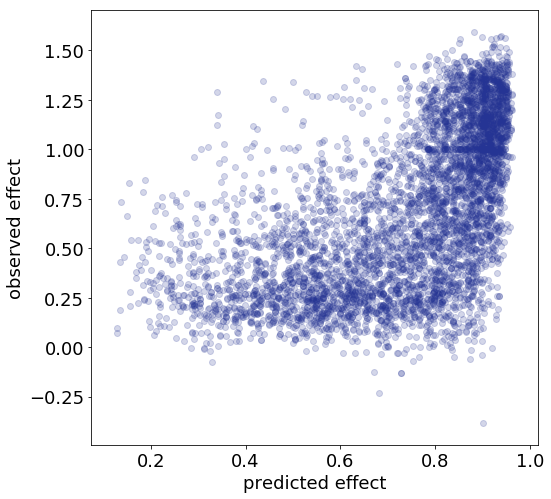

(0.58501215827271891, 0.0)

In [20]:
Kka2_2_data = data2.filter_by([x for x in data2['dms_id'].unique() if x in ['kka2_1:2']], 'dms_id')
Kka2_2_data2 = Kka2_2_data.filter_by([x for x in Kka2_2_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del Kka2_2_data2['id']
Kka2_2_data2 = Kka2_2_data2.add_row_number('id',0)
Kka2_2_data2['selection_coef|ficient'] = .4

pred = NoKka2_model.predict(Kka2_2_data2)
stats.pearsonr(pred, Kka2_2_data2['scaled_effect1'])

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('predicted effect')
ax.set_ylabel('observed effect')
ax.set_ylim([0,1.6])
ax.set_xlim([-0.2,1.6])
ax.scatter(pred,Kka2_2_data2['scaled_effect1'], alpha = 0.2, color = '#253494')
ax.axis('tight')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.show()

stats.pearsonr(pred, Kka2_2_data2['scaled_effect1'])
#stats.spearmanr(pred, Kka2_2_data2['scaled_effect1'])
#sqrt(mean_squared_error(pred,Kka2_2_data2['scaled_effect1']))

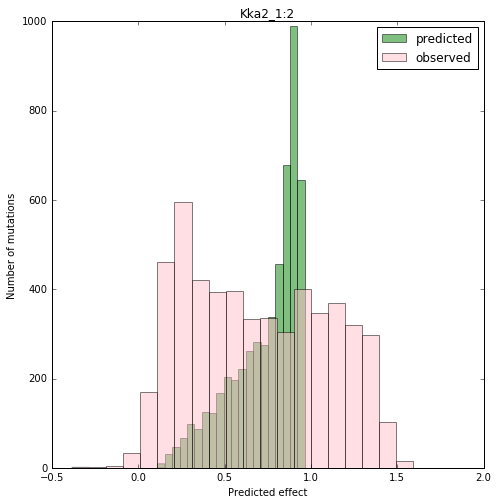

In [26]:
## histogram of predictions
num_bins = 20
# the histogram of the data
plt.hist(pred, num_bins, facecolor='green', alpha=0.5, label = "predicted")
plt.hist(Kka2_2_data2['scaled_effect1'], num_bins, facecolor='pink', alpha=0.5,
        label = "observed")
plt.xlabel('Predicted effect')
plt.ylabel('Number of mutations')
plt.title(r'Kka2_1:2')
plt.legend(loc='upper right')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

In [30]:
params = dict([('target', 'scaled_effect1'), ('max_depth', 5), ('max_iterations' , [10,25,50,100,250]), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , 1), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

params1 = dict([('target', 'scaled_effect1'), ('max_depth', [2, 6, 10, 25, 50] ), ('max_iterations' , 25), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , [2, 6, 10, 25, 50]), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

params2 = dict([('target', 'scaled_effect1'), ('max_depth',25), ('max_iterations' , 25), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' ,10 ), 
               ('min_loss_reduction' , [0, 0.1, 0.2, 0.3, 0.4, 0.5]), ('step_size' , 0.1), ('features' , [predictors3])])

params3 = dict([('target', 'scaled_effect1'), ('max_depth',25), ('max_iterations' , 25), 
               ('column_subsample' , [0.6, 0.7, 0.8, 0.9]), ('row_subsample' , [0.6, 0.7, 0.8, 0.9]), ('min_child_weight' ,10 ), 
               ('min_loss_reduction' ,  0.5), ('step_size' , 0.1), ('features' , [predictors3])])

In [21]:
## PSD95pdz3 
NOPSD95pdz3_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['PSD95pdz3']], 'protein')
NOPSD95pdz3_data2 = NOPSD95pdz3_data.filter_by([x for x in NOPSD95pdz3_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOPSD95pdz3_data2['id']
NOPSD95pdz3_data2 = NOPSD95pdz3_data2.add_row_number('id',0)

folds = gl.cross_validation.KFold(NOPSD95pdz3_data2,10)

In [31]:
lopo_output_protein_PSD95pdz3 = gl.model_parameter_search.grid_search.create(folds, gl.boosted_trees_regression.create, params3)   


[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-09-2017-18-00-2100000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-09-2017-18-00-2100000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Aug-09-2017-18-00-2100000' already exists. Renaming the job to 'Model-Parameter-Search-Aug-09-2017-18-00-2100000-cf0c6'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-09-2017-18-00-2100000-cf0c6' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-09-2017-18-00-2100000-cf0c6' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-09-2017-18-00-2100001' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-09-2017-18-00

In [32]:
lopo_output_protein_PSD95pdz3.get_best_params()

{'column_subsample': 0.6,
 'features': ['aa1',
  'aa2',
  'wt_mut',
  'aa1_polarity',
  'aa2_polarity',
  'aa1_PI',
  'aa2_PI',
  'deltaPI',
  'Grantham',
  'aa1_weight',
  'aa2_weight',
  'deltaWeight',
  'aa1vol',
  'aa2vol',
  'deltavolume',
  'aa1_psic',
  'aa2_psic',
  'delta_psic',
  'accessibility',
  'dssp_sec_str',
  'phi_psi_reg',
  'delta_solvent_accessibility',
  'b_factor',
  'mut_msa_congruency',
  'mut_mut_msa_congruency',
  'seq_ind_closest_mut',
  'evolutionary_coupling_avg'],
 'max_depth': 25,
 'max_iterations': 25,
 'min_child_weight': 10,
 'min_loss_reduction': 0.5,
 'row_subsample': 0.8,
 'step_size': 0.1,
 'target': 'scaled_effect1'}

In [33]:
## PSD95pdz3 
NOPSD95pdz3_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['PSD95pdz3']], 'protein')
NOPSD95pdz3_data2 = NOPSD95pdz3_data.filter_by([x for x in NOPSD95pdz3_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOPSD95pdz3_data2['id']
NOPSD95pdz3_data2 = NOPSD95pdz3_data2.add_row_number('id',0)
NoPSD95pdz3_model = gl.boosted_trees_regression.create(NOPSD95pdz3_data2, 'scaled_effect1', features = predictors3, max_iterations = 125,
                                                   column_subsample = 0.6, row_subsample = 0.8,
                                                           min_child_weight = 10, min_loss_reduction = 0.5, step_size = 0.01, max_depth = 25)


PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees regression:

--------------------------------------------------------

Number of examples          : 25593

Number of features          : 27

Number of unpacked features : 27

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 0.192829     | 1.162506           | 0.946688             | 0.421218      | 0.421230        |

| 2         | 0.403371     | 1.158329           | 0.941471             | 0.418160      | 0.418330        |

| 3         | 0.637962     | 1.153670           | 0.937070             | 0.415144      | 0.415457        |

| 4         | 0.858963     | 1.149181           | 0.930956             | 0.412081      | 0.412501        |

| 5         | 1.081847     | 1.145404           | 0.926136             | 0.409043      | 0.409621        |

| 6         | 1.297054     | 1.140934           | 0.921718             | 0.406182      | 0.406876        |

| 10        | 2.184809     | 1.123568           | 0.914490             | 0.394839      | 0.396046        |

| 11        | 2.393302     | 1.119492           | 0.918420             | 0.392118      | 0.393432        |

| 15        | 3.311815     | 1.103804           | 0.926721             | 0.381310      | 0.383292        |

| 20        | 4.447372     | 1.083344           | 0.943789             | 0.368526      | 0.371133        |

| 25        | 5.560748     | 1.065511           | 0.961469             | 0.356483      | 0.359751        |

| 30        | 6.718370     | 1.048102           | 0.978036             | 0.345244      | 0.349266        |

| 35        | 7.781116     | 1.034779           | 0.989989             | 0.334441      | 0.339105        |

| 40        | 8.905407     | 1.018756           | 1.002629             | 0.324476      | 0.329855        |

| 45        | 10.086663    | 1.003751           | 1.005828             | 0.314866      | 0.320914        |

| 50        | 11.716398    | 0.989535           | 1.020985             | 0.305909      | 0.312791        |

| 51        | 11.933430    | 0.986452           | 1.023810             | 0.304163      | 0.311216        |

| 55        | 12.875576    | 0.982148           | 1.033475             | 0.297451      | 0.305162        |

| 60        | 14.021962    | 0.990148           | 1.044377             | 0.289424      | 0.297899        |

| 65        | 15.165110    | 0.994457           | 1.054165             | 0.282190      | 0.291370        |

| 70        | 16.322900    | 1.000541           | 1.059552             | 0.275310      | 0.285184        |

| 75        | 17.494188    | 1.008506           | 1.070079             | 0.268832      | 0.279386        |

| 80        | 18.556121    | 1.016768           | 1.077475             | 0.262747      | 0.273920        |

| 85        | 19.718538    | 1.019600           | 1.084435             | 0.256785      | 0.268638        |

| 90        | 20.964298    | 1.025336           | 1.092470             | 0.251280      | 0.263778        |

| 95        | 22.145791    | 1.034793           | 1.098209             | 0.246105      | 0.259284        |

| 100       | 23.393305    | 1.037931           | 1.103285             | 0.241534      | 0.255367        |

| 101       | 23.605599    | 1.039403           | 1.104695             | 0.240745      | 0.254710        |

| 105       | 24.516392    | 1.042757           | 1.106435             | 0.237148      | 0.251693        |

| 110       | 25.752982    | 1.048132           | 1.112104             | 0.233151      | 0.248288        |

| 115       | 26.993990    | 1.054029           | 1.120177             | 0.229371      | 0.245036        |

| 120       | 28.170977    | 1.060350           | 1.130189             | 0.225665      | 0.242004        |

| 125       | 29.434992    | 1.061635           | 1.135435             | 0.222238      | 0.239157        |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

In [35]:
PSD95pdz3_data = data2.filter_by([x for x in data2['protein'].unique() if x in ['PSD95pdz3']], 'protein')
PSD95pdz3_data2 = PSD95pdz3_data.filter_by([x for x in PSD95pdz3_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del PSD95pdz3_data2['id']
PSD95pdz3_data2 = PSD95pdz3_data2.add_row_number('id',0)

pred = NoPSD95pdz3_model.predict(PSD95pdz3_data2)
stats.pearsonr(pred, PSD95pdz3_data2['scaled_effect1'])
#stats.spearmanr(pred, PSD95pdz3_data2['scaled_effect1'])
#sqrt(mean_squared_error(pred,PSD95pdz3_data2['scaled_effect1']))

(0.43128435221916994, 1.9115570110937094e-72)

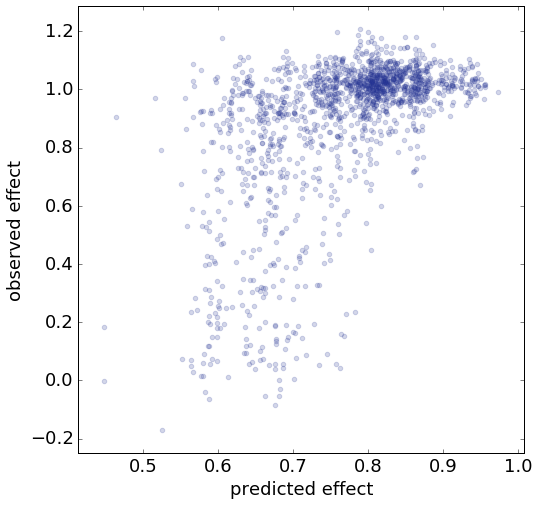

In [18]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('predicted effect')
ax.set_ylabel('observed effect')
ax.set_ylim([0,1.6])
ax.set_xlim([-0.2,1.6])
ax.scatter(pred,PSD95pdz3_data2['scaled_effect1'], alpha = 0.2, color = '#253494')
ax.axis('tight')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.show()

In [88]:
pickler = gl._gl_pickle.GLPickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/NoPSD95pdz3_model_regressionModel_noSELCO_limited_2017-02-08')
pickler.dump(NoPSD95pdz3_model)
pickler.close()

In [23]:
unpickler = gl._gl_pickle.GLUnpickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/NoPSD95pdz3_model_regressionModel_noSELCO_limited_2017-02-08')
NoPSD95pdz3_model = unpickler.load()
unpickler.close()

In [14]:
params = dict([('target', 'scaled_effect1'), ('max_depth', 5), ('max_iterations' , [10,25,50,100,250]), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , 1), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

params1 = dict([('target', 'scaled_effect1'), ('max_depth', [2, 6, 10, 25, 50] ), ('max_iterations' , 25), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , [2, 6, 10, 25, 50]), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

params2 = dict([('target', 'scaled_effect1'), ('max_depth',2), ('max_iterations' , 25), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' ,50 ), 
               ('min_loss_reduction' , [0, 0.1, 0.2, 0.3, 0.4, 0.5]), ('step_size' , 0.1), ('features' , [predictors3])])

params3 = dict([('target', 'scaled_effect1'), ('max_depth',2), ('max_iterations' , 25), 
               ('column_subsample' , [0.6, 0.7, 0.8, 0.9]), ('row_subsample' , [0.6, 0.7, 0.8, 0.9]), ('min_child_weight' ,50 ), 
               ('min_loss_reduction' ,  0), ('step_size' , 0.1), ('features' , [predictors3])])

In [15]:
## Pab1 
NOPab1_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['Pab1']], 'protein')
NOPab1_data2 = NOPab1_data.filter_by([x for x in NOPab1_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOPab1_data2['id']
NOPab1_data2 = NOPab1_data2.add_row_number('id',0)

folds = gl.cross_validation.KFold(NOPab1_data2,10)
    
lopo_output_protein_Pab1 = gl.model_parameter_search.grid_search.create(folds, gl.boosted_trees_regression.create, params3)

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-10-2017-10-21-5200000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-10-2017-10-21-5200000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Aug-10-2017-10-21-5200000' already exists. Renaming the job to 'Model-Parameter-Search-Aug-10-2017-10-21-5200000-9dcc0'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-10-2017-10-21-5200000-9dcc0' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-10-2017-10-21-5200000-9dcc0' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-10-2017-10-21-5200001' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-10-2017-10-21

In [16]:
lopo_output_protein_Pab1.get_best_params()

{'column_subsample': 0.7,
 'features': ['aa1',
  'aa2',
  'wt_mut',
  'aa1_polarity',
  'aa2_polarity',
  'aa1_PI',
  'aa2_PI',
  'deltaPI',
  'Grantham',
  'aa1_weight',
  'aa2_weight',
  'deltaWeight',
  'aa1vol',
  'aa2vol',
  'deltavolume',
  'aa1_psic',
  'aa2_psic',
  'delta_psic',
  'accessibility',
  'dssp_sec_str',
  'phi_psi_reg',
  'delta_solvent_accessibility',
  'b_factor',
  'mut_msa_congruency',
  'mut_mut_msa_congruency',
  'seq_ind_closest_mut',
  'evolutionary_coupling_avg'],
 'max_depth': 2,
 'max_iterations': 25,
 'min_child_weight': 50,
 'min_loss_reduction': 0,
 'row_subsample': 0.6,
 'step_size': 0.1,
 'target': 'scaled_effect1'}

In [77]:
NOPab1_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['Pab1']], 'protein')
NOPab1_data2 = NOPab1_data.filter_by([x for x in NOPab1_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOPab1_data2['id']
NOPab1_data2 = NOPab1_data2.add_row_number('id',0)

In [17]:

NoPab1_model = gl.boosted_trees_regression.create(NOPab1_data2, 'scaled_effect1', features = predictors3, 
                                                  max_iterations = 125, column_subsample = 0.7, row_subsample = 0.6, 
                                                  min_child_weight = 50, min_loss_reduction = 0, step_size = 0.01, 
                                                  max_depth = 2)


PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees regression:

--------------------------------------------------------

Number of examples          : 26007

Number of features          : 27

Number of unpacked features : 27

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 0.083889     | 1.163954           | 1.013675             | 0.425396      | 0.424392        |

| 2         | 0.146344     | 1.159947           | 1.009669             | 0.423022      | 0.421993        |

| 3         | 0.204765     | 1.156009           | 1.007046             | 0.420778      | 0.419771        |

| 4         | 0.263889     | 1.152068           | 1.003105             | 0.418426      | 0.417392        |

| 5         | 0.321476     | 1.149600           | 0.999228             | 0.416198      | 0.415227        |

| 6         | 0.383459     | 1.146483           | 0.995038             | 0.414021      | 0.413081        |

| 11        | 0.653026     | 1.128899           | 0.976366             | 0.403377      | 0.402429        |

| 25        | 1.381317     | 1.083435           | 0.942306             | 0.377124      | 0.376298        |

| 50        | 2.470683     | 1.038925           | 0.922241             | 0.341531      | 0.341123        |

| 51        | 2.512155     | 1.041057           | 0.920846             | 0.340394      | 0.340017        |

| 75        | 3.375280     | 1.086800           | 0.904658             | 0.317011      | 0.317205        |

| 100       | 4.164308     | 1.122009           | 0.877041             | 0.300050      | 0.300796        |

| 101       | 4.195506     | 1.123706           | 0.875344             | 0.299493      | 0.300276        |

| 125       | 4.866204     | 1.152560           | 0.854868             | 0.288516      | 0.289851        |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

In [84]:
pickler = gl._gl_pickle.GLPickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/NoPab1_model_regressionModel_noSELCO_limited_2017-02-08')
pickler.dump(NoPab1_model)
pickler.close()

In [24]:
unpickler = gl._gl_pickle.GLUnpickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/NoPab1_model_regressionModel_noSELCO_limited_2017-02-08')
NoPab1_model = unpickler.load()
unpickler.close()

In [19]:
## Pab1 
Pab1_data = data2.filter_by([x for x in data2['protein'].unique() if x in ['Pab1']], 'protein')
Pab1_data2 = Pab1_data.filter_by([x for x in Pab1_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del Pab1_data2['id']
Pab1_data2 = Pab1_data2.add_row_number('id',0)

pred = NoPab1_model.predict(Pab1_data2)
stats.pearsonr(pred, Pab1_data2['scaled_effect1'])
#stats.spearmanr(pred, Pab1_data2['scaled_effect1'])
#sqrt(mean_squared_error(pred,Pab1_data2['scaled_effect1']))

(0.5133869961957791, 7.3052465815131817e-81)

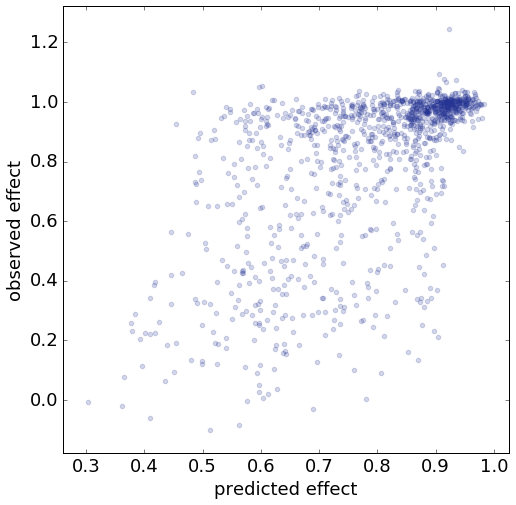

In [22]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('predicted effect')
ax.set_ylabel('observed effect')
ax.set_ylim([0,1.6])
ax.set_xlim([-0.2,1.6])
ax.scatter(pred,Pab1_data2['scaled_effect1'], alpha = 0.2, color = '#253494')
ax.axis('tight')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.show()

In [20]:
## beta_lact 
NObeta_lact_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['TEM-1']], 'protein')
NObeta_lact_data2 = NObeta_lact_data.filter_by([x for x in NObeta_lact_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NObeta_lact_data2['id']
NObeta_lact_data2 = NObeta_lact_data2.add_row_number('id',0)

folds = gl.cross_validation.KFold(NObeta_lact_data2,10)


In [28]:
params = dict([('target', 'scaled_effect1'), ('max_depth', 5), ('max_iterations' , [10,25,50,100,250]), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , 1), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

params1 = dict([('target', 'scaled_effect1'), ('max_depth', [2, 6, 10, 25, 50] ), ('max_iterations' , 50), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , [2, 6, 10, 25, 50]), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

params2 = dict([('target', 'scaled_effect1'), ('max_depth',2), ('max_iterations' , 50), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' ,50 ), 
               ('min_loss_reduction' , [0, 0.1, 0.2, 0.3, 0.4, 0.5]), ('step_size' , 0.1), ('features' , [predictors3])])

params3 = dict([('target', 'scaled_effect1'), ('max_depth',2), ('max_iterations' , 50), 
               ('column_subsample' , [0.6, 0.7, 0.8, 0.9]), ('row_subsample' , [0.6, 0.7, 0.8, 0.9]), ('min_child_weight' ,50 ), 
               ('min_loss_reduction' ,  0), ('step_size' , 0.1), ('features' , [predictors3])])

In [29]:
lopo_output_protein_beta_lact = gl.model_parameter_search.grid_search.create(folds, gl.boosted_trees_regression.create, params3)

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-10-2017-12-35-2300000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-10-2017-12-35-2300000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Aug-10-2017-12-35-2300000' already exists. Renaming the job to 'Model-Parameter-Search-Aug-10-2017-12-35-2300000-fc8e2'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-10-2017-12-35-2300000-fc8e2' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-10-2017-12-35-2300000-fc8e2' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-10-2017-12-35-2300001' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-10-2017-12-35

In [30]:
lopo_output_protein_beta_lact.get_best_params()

{'column_subsample': 0.8,
 'features': ['aa1',
  'aa2',
  'wt_mut',
  'aa1_polarity',
  'aa2_polarity',
  'aa1_PI',
  'aa2_PI',
  'deltaPI',
  'Grantham',
  'aa1_weight',
  'aa2_weight',
  'deltaWeight',
  'aa1vol',
  'aa2vol',
  'deltavolume',
  'aa1_psic',
  'aa2_psic',
  'delta_psic',
  'accessibility',
  'dssp_sec_str',
  'phi_psi_reg',
  'delta_solvent_accessibility',
  'b_factor',
  'mut_msa_congruency',
  'mut_mut_msa_congruency',
  'seq_ind_closest_mut',
  'evolutionary_coupling_avg'],
 'max_depth': 2,
 'max_iterations': 50,
 'min_child_weight': 50,
 'min_loss_reduction': 0,
 'row_subsample': 0.6,
 'step_size': 0.1,
 'target': 'scaled_effect1'}

In [71]:
NObeta_lact_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['TEM-1']], 'protein')
NObeta_lact_data2 = NObeta_lact_data.filter_by([x for x in NObeta_lact_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NObeta_lact_data2['id']
NObeta_lact_data2 = NObeta_lact_data2.add_row_number('id',0)

In [32]:
## TEM-1
## beta_lact 
Nobeta_lact_model = gl.boosted_trees_regression.create(NObeta_lact_data2, 'scaled_effect1', 
                                                       features = predictors3, max_iterations = 250,
                                                   column_subsample = 0.8, row_subsample = 0.6,
                                                           min_child_weight = 50, min_loss_reduction = 0, 
                                                       step_size = 0.01, max_depth = 2)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees regression:

--------------------------------------------------------

Number of examples          : 22207

Number of features          : 27

Number of unpacked features : 27

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 0.018263     | 1.164466           | 1.062666             | 0.430835      | 0.427882        |

| 2         | 0.032419     | 1.160442           | 1.058641             | 0.428388      | 0.425485        |

| 3         | 0.049342     | 1.155731           | 1.055069             | 0.425937      | 0.423075        |

| 4         | 0.067632     | 1.151760           | 1.051098             | 0.423580      | 0.420761        |

| 5         | 0.087225     | 1.147154           | 1.047662             | 0.421289      | 0.418518        |

| 6         | 0.106260     | 1.143307           | 1.043815             | 0.418985      | 0.416250        |

| 11        | 0.197573     | 1.126434           | 1.024665             | 0.407938      | 0.405476        |

| 51        | 0.930415     | 1.031260           | 0.906726             | 0.343341      | 0.342982        |

| 100       | 1.836321     | 1.109045           | 0.823315             | 0.302520      | 0.304475        |

| 101       | 1.857385     | 1.110458           | 0.821901             | 0.301962      | 0.303956        |

| 200       | 3.663434     | 1.179136           | 0.817141             | 0.273371      | 0.277874        |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

In [76]:
pickler = gl._gl_pickle.GLPickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/Nobeta_lact_model_regressionModel_noSELCO_limited_2017-02-08')
pickler.dump(Nobeta_lact_model)
pickler.close()

In [26]:
unpickler = gl._gl_pickle.GLUnpickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/Nobeta_lact_model_regressionModel_noSELCO_limited_2017-02-08')
Nobeta_lact_model = unpickler.load()
unpickler.close()

In [34]:
## beta_lact 
beta_lact_data = data2.filter_by([x for x in data2['protein'].unique() if x in ['TEM-1']], 'protein')
beta_lact_data2 = beta_lact_data.filter_by([x for x in beta_lact_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del beta_lact_data2['id']
beta_lact_data2 = beta_lact_data2.add_row_number('id',0)

pred = Nobeta_lact_model.predict(beta_lact_data2)
stats.pearsonr(pred, beta_lact_data2['scaled_effect1'])
stats.spearmanr(pred, beta_lact_data2['scaled_effect1'])
#sqrt(mean_squared_error(pred,beta_lact_data2['scaled_effect1']))

SpearmanrResult(correlation=0.6997959143680782, pvalue=0.0)

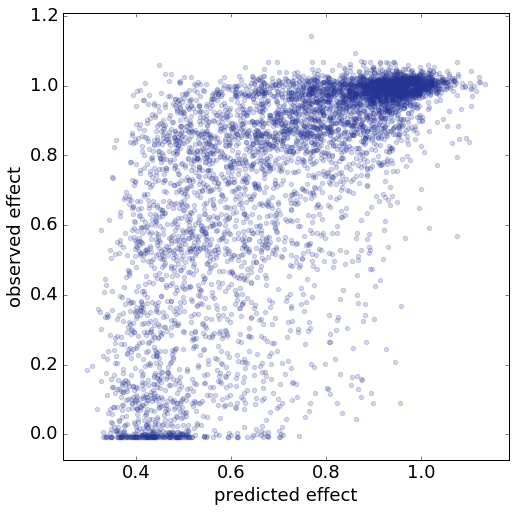

In [25]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('predicted effect')
ax.set_ylabel('observed effect')
ax.set_ylim([0,1.6])
ax.set_xlim([-0.2,1.6])
ax.scatter(pred,beta_lact_data2['scaled_effect1'], alpha = 0.2, color = '#253494')
ax.axis('tight')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.show()

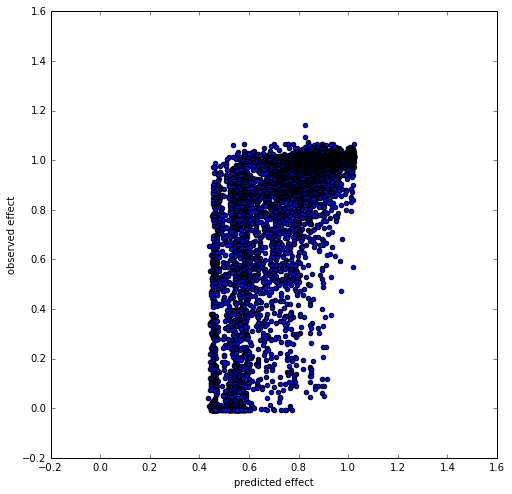

(0.64075281241660664, 0.0)

In [50]:
## beta_lactamase
beta_lact_data = data2.filter_by([x for x in data2['dms_id'].unique() if x in ['beta-lactamase']], 'dms_id')
beta_lact_data2 = beta_lact_data.filter_by([x for x in beta_lact_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del beta_lact_data2['id']
beta_lact_data2 = beta_lact_data2.add_row_number('id',0)

pred = Nobeta_lact_model.predict(beta_lact_data2)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('predicted effect')
ax.set_ylabel('observed effect')
ax.set_ylim([-0.2,1.6])
ax.set_xlim([-0.2,1.6])
ax.scatter(pred,beta_lact_data2['scaled_effect1'])
plt.show()

stats.pearsonr(pred, beta_lact_data2['scaled_effect1'])
#stats.spearmanr(pred, beta_lact_data2['scaled_effect1'])
#sqrt(mean_squared_error(pred,beta_lact_data2['scaled_effect1']))

In [ ]:
## Tack all of the beta-lact predictions onto a dataset

In [45]:
params = dict([('target', 'scaled_effect1'), ('max_depth', 5), ('max_iterations' , [10,25,50,100,250]), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , 1), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

params1 = dict([('target', 'scaled_effect1'), ('max_depth', [2, 6, 10, 25, 50] ), ('max_iterations' , 25), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , [2, 6, 10, 25, 50]), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

params2 = dict([('target', 'scaled_effect1'), ('max_depth',2), ('max_iterations' , 25), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' ,6 ), 
               ('min_loss_reduction' , [0, 0.1, 0.2, 0.3, 0.4, 0.5]), ('step_size' , 0.1), ('features' , [predictors3])])

params3 = dict([('target', 'scaled_effect1'), ('max_depth',2), ('max_iterations' , 25), 
               ('column_subsample' , [0.6, 0.7, 0.8, 0.9]), ('row_subsample' , [0.6, 0.7, 0.8, 0.9]), ('min_child_weight' ,6), 
               ('min_loss_reduction' ,  0.3), ('step_size' , 0.1), ('features' , [predictors3])])

In [46]:
## Uba1 
NOUba1_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['UBI4']], 'protein')
NOUba1_data2 = NOUba1_data.filter_by([x for x in NOUba1_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOUba1_data2['id']
NOUba1_data2 = NOUba1_data2.add_row_number('id',0)

folds = gl.cross_validation.KFold(NOUba1_data2,10)
    
lopo_output_protein_Uba1 = gl.model_parameter_search.grid_search.create(folds, gl.boosted_trees_regression.create, params3)


[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-10-2017-14-28-2000000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-10-2017-14-28-2000000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Aug-10-2017-14-28-2000000' already exists. Renaming the job to 'Model-Parameter-Search-Aug-10-2017-14-28-2000000-f07c3'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-10-2017-14-28-2000000-f07c3' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-10-2017-14-28-2000000-f07c3' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-10-2017-14-28-2000001' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-10-2017-14-28

In [47]:
lopo_output_protein_Uba1.get_best_params()

{'column_subsample': 0.8,
 'features': ['aa1',
  'aa2',
  'wt_mut',
  'aa1_polarity',
  'aa2_polarity',
  'aa1_PI',
  'aa2_PI',
  'deltaPI',
  'Grantham',
  'aa1_weight',
  'aa2_weight',
  'deltaWeight',
  'aa1vol',
  'aa2vol',
  'deltavolume',
  'aa1_psic',
  'aa2_psic',
  'delta_psic',
  'accessibility',
  'dssp_sec_str',
  'phi_psi_reg',
  'delta_solvent_accessibility',
  'b_factor',
  'mut_msa_congruency',
  'mut_mut_msa_congruency',
  'seq_ind_closest_mut',
  'evolutionary_coupling_avg'],
 'max_depth': 2,
 'max_iterations': 25,
 'min_child_weight': 6,
 'min_loss_reduction': 0.3,
 'row_subsample': 0.6,
 'step_size': 0.1,
 'target': 'scaled_effect1'}

In [49]:
## Uba1 
NOUba1_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['UBI4']], 'protein')
NOUba1_data2 = NOUba1_data.filter_by([x for x in NOUba1_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOUba1_data2['id']
NOUba1_data2 = NOUba1_data2.add_row_number('id',0)
NoUba1_model = gl.boosted_trees_regression.create(NOUba1_data2, 'scaled_effect1', features = predictors3, max_iterations = 125,
                                                   column_subsample = 0.8, row_subsample = 0.6,
                                                           min_child_weight = 6, min_loss_reduction = 0.3, step_size = 0.01, max_depth = 2)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees regression:

--------------------------------------------------------

Number of examples          : 24877

Number of features          : 27

Number of unpacked features : 27

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 0.033494     | 1.164197           | 1.051805             | 0.425007      | 0.430835        |

| 2         | 0.054650     | 1.160120           | 1.047729             | 0.422577      | 0.428452        |

| 3         | 0.075679     | 1.156162           | 1.043770             | 0.420197      | 0.426111        |

| 4         | 0.095597     | 1.152203           | 1.039811             | 0.417815      | 0.423795        |

| 5         | 0.116673     | 1.148973           | 1.036581             | 0.415602      | 0.421636        |

| 6         | 0.138128     | 1.145137           | 1.032745             | 0.413301      | 0.419396        |

| 11        | 0.236143     | 1.127314           | 1.014922             | 0.402398      | 0.408647        |

| 50        | 0.995475     | 1.039713           | 0.905431             | 0.339674      | 0.347877        |

| 51        | 1.015455     | 1.042138           | 0.903007             | 0.338462      | 0.346724        |

| 100       | 1.964620     | 1.130035           | 0.822496             | 0.297739      | 0.307952        |

| 101       | 1.984775     | 1.131481           | 0.821049             | 0.297210      | 0.307480        |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

In [16]:
pickler = gl._gl_pickle.GLPickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/NoUba1_model_regressionModel_noSELCO_limited_2017-02-08')
pickler.dump(NoUba1_model)
pickler.close()

In [35]:
unpickler = gl._gl_pickle.GLUnpickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/NoUba1_model_regressionModel_noSELCO_limited_2017-02-08')
NoUba1_model = unpickler.load()
unpickler.close()

In [50]:
## Uba1 
Uba1_data = data2.filter_by([x for x in data2['protein'].unique() if x in ['UBI4']], 'protein')
Uba1_data2 = Uba1_data.filter_by([x for x in Uba1_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del Uba1_data2['id']
Uba1_data2 = Uba1_data2.add_row_number('id',0)

pred = NoUba1_model.predict(Uba1_data2)
stats.pearsonr(pred, Uba1_data2['scaled_effect1'])
#stats.spearmanr(pred, Uba1_data2['scaled_effect1'])
#sqrt(mean_squared_error(pred,Uba1_data2['scaled_effect1']))

(0.31190169760841102, 7.8646187526251399e-54)

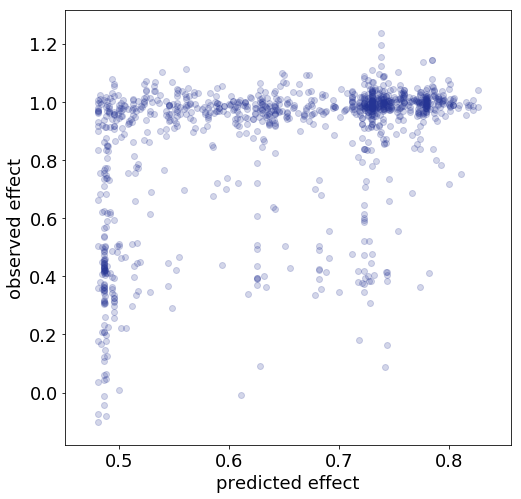

(0.44500649046748519, 6.854072803636459e-54)

In [53]:
## ubiq_e1
ubiq_e1_data = data2.filter_by([x for x in data2['dms_id'].unique() if x in ['E1_Ubiquitin']], 'dms_id')
ubiq_e1_data2 = ubiq_e1_data.filter_by([x for x in ubiq_e1_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del ubiq_e1_data2['id']
ubiq_e1_data2 = ubiq_e1_data2.add_row_number('id',0)

pred = NoUba1_model.predict(ubiq_e1_data2)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('predicted effect')
ax.set_ylabel('observed effect')
ax.set_ylim([0,1.6])
ax.set_xlim([-0.2,1.6])
ax.scatter(pred,ubiq_e1_data2['scaled_effect1'], alpha = 0.2, color = '#253494')
ax.axis('tight')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.show()

stats.pearsonr(pred, ubiq_e1_data2['scaled_effect1'])
#stats.spearmanr(pred, ubiq_e1_data2['scaled_effect1'])
#sqrt(mean_squared_error(pred,ubiq_e1_data2['scaled_effect1']))

/net/gs/vol3/software/modules-sw-python/2.7.3/matplotlib/2.0.2_4430-UCS4/Linux/RHEL6/x86_64/lib/python2.7/site-packages/matplotlib-2.0.2+4430.g2a7237c-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


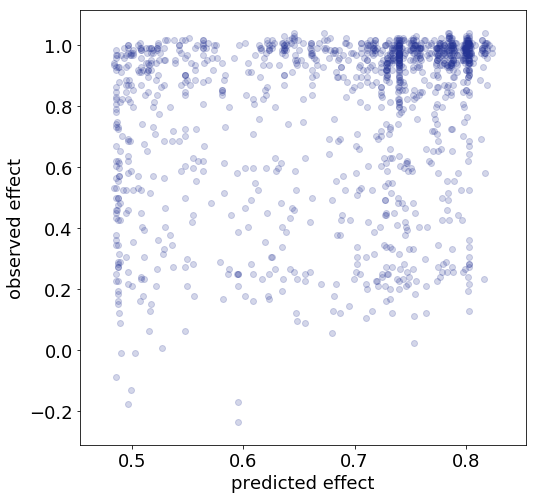

(0.26827952586320564, 4.9514970254252856e-22)

In [52]:
## ubiquitin
ubiq_data = data2.filter_by([x for x in data2['dms_id'].unique() if x in ['Ubiquitin']], 'dms_id')
ubiq_data2 = ubiq_data.filter_by([x for x in ubiq_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del ubiq_data2['id']
ubiq_data2 = ubiq_data2.add_row_number('id',0)

pred = NoUba1_model.predict(ubiq_data2)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('predicted effect')
ax.set_ylabel('observed effect')
ax.set_ylim([0,1.6])
ax.set_xlim([-0.2,1.6])
ax.scatter(pred,ubiq_data2['scaled_effect1'], alpha = 0.2, color = '#253494')
ax.axis('tight')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.show()

stats.pearsonr(pred, ubiq_data2['scaled_effect1'])
#stats.spearmanr(pred, ubiq_data2['scaled_effect1'])
#sqrt(mean_squared_error(pred,ubiq_data2['scaled_effect1']))

In [21]:
params = dict([('target', 'scaled_effect1'), ('max_depth', 5), ('max_iterations' , [10,25,50,100,250]), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , 1), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

In [57]:
params1 = dict([('target', 'scaled_effect1'), ('max_depth', [2, 6, 10, 25, 50] ), ('max_iterations' , 25), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , [2, 6, 10, 25, 50]), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

In [60]:
params2 = dict([('target', 'scaled_effect1'), ('max_depth',2), ('max_iterations' , 25), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' ,10 ), 
               ('min_loss_reduction' , [0, 0.1, 0.2, 0.3, 0.4, 0.5]), ('step_size' , 0.1), ('features' , [predictors3])])

In [64]:
params3 = dict([('target', 'scaled_effect1'), ('max_depth',2), ('max_iterations' , 25), 
               ('column_subsample' , [0.6, 0.7, 0.8, 0.9]), ('row_subsample' , [0.6, 0.7, 0.8, 0.9]), ('min_child_weight' ,10), 
               ('min_loss_reduction' ,  0.1), ('step_size' , 0.3), ('features' , [predictors3])])

In [54]:
## Yap65 
NOYap65_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['Yap65']], 'protein')
NOYap65_data2 = NOYap65_data.filter_by([x for x in NOYap65_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOYap65_data2['id']
NOYap65_data2 = NOYap65_data2.add_row_number('id',0)

folds = gl.cross_validation.KFold(NOYap65_data2,10)

In [59]:
## Yap65 
NOYap65_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['Yap65']], 'protein')
NOYap65_data2 = NOYap65_data.filter_by([x for x in NOYap65_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOYap65_data2['id']
NOYap65_data2 = NOYap65_data2.add_row_number('id',0)

In [65]:
lopo_output_protein_Yap65 = gl.model_parameter_search.grid_search.create(folds, gl.boosted_trees_regression.create, params3)


[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-10-2017-16-09-1400000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-10-2017-16-09-1400000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Aug-10-2017-16-09-1400000' already exists. Renaming the job to 'Model-Parameter-Search-Aug-10-2017-16-09-1400000-f9e60'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-10-2017-16-09-1400000-f9e60' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-10-2017-16-09-1400000-f9e60' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-10-2017-16-09-1400001' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-10-2017-16-09

In [66]:
lopo_output_protein_Yap65.get_best_params()

{'column_subsample': 0.7,
 'features': ['aa1',
  'aa2',
  'wt_mut',
  'aa1_polarity',
  'aa2_polarity',
  'aa1_PI',
  'aa2_PI',
  'deltaPI',
  'Grantham',
  'aa1_weight',
  'aa2_weight',
  'deltaWeight',
  'aa1vol',
  'aa2vol',
  'deltavolume',
  'aa1_psic',
  'aa2_psic',
  'delta_psic',
  'accessibility',
  'dssp_sec_str',
  'phi_psi_reg',
  'delta_solvent_accessibility',
  'b_factor',
  'mut_msa_congruency',
  'mut_mut_msa_congruency',
  'seq_ind_closest_mut',
  'evolutionary_coupling_avg'],
 'max_depth': 2,
 'max_iterations': 25,
 'min_child_weight': 10,
 'min_loss_reduction': 0.1,
 'row_subsample': 0.9,
 'step_size': 0.3,
 'target': 'scaled_effect1'}

In [67]:
## Yap65 
NoYap65_model = gl.boosted_trees_regression.create(NOYap65_data2, 'scaled_effect1', features = predictors3, max_iterations = 250,
                                                   column_subsample = 0.7, row_subsample = 0.9,
                                                           min_child_weight = 10, min_loss_reduction = 0.1, step_size = 0.01, max_depth = 2)


PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees regression:

--------------------------------------------------------

Number of examples          : 26792

Number of features          : 27

Number of unpacked features : 27

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 0.023670     | 1.164672           | 1.064116             | 0.424532      | 0.422870        |

| 2         | 0.040811     | 1.161304           | 1.060904             | 0.422354      | 0.420728        |

| 3         | 0.060042     | 1.158664           | 1.058265             | 0.420092      | 0.418496        |

| 4         | 0.078535     | 1.156058           | 1.055659             | 0.417868      | 0.416303        |

| 5         | 0.098335     | 1.152084           | 1.051685             | 0.415545      | 0.414035        |

| 6         | 0.116023     | 1.148173           | 1.047773             | 0.413306      | 0.411873        |

| 11        | 0.211007     | 1.132879           | 1.029304             | 0.402543      | 0.401411        |

| 51        | 0.947527     | 1.037719           | 0.947728             | 0.339156      | 0.339818        |

| 100       | 1.856470     | 1.122561           | 0.888678             | 0.298914      | 0.300521        |

| 101       | 1.878214     | 1.123487           | 0.889360             | 0.298370      | 0.300006        |

| 200       | 3.688676     | 1.195198           | 0.850229             | 0.269485      | 0.271643        |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

In [136]:
pickler = gl._gl_pickle.GLPickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/NoYap65_model_regressionModel_noSELCO_limited_2017-02-08')
pickler.dump(NoYap65_model)
pickler.close()

In [29]:
unpickler = gl._gl_pickle.GLUnpickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/NoYap65_model_regressionModel_noSELCO_limited_2017-02-08')
NoYap65_model = unpickler.load()
unpickler.close()

In [69]:
## Yap65 
Yap65_data = data2.filter_by([x for x in data2['protein'].unique() if x in ['Yap65']], 'protein')
Yap65_data2 = Yap65_data.filter_by([x for x in Yap65_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del Yap65_data2['id']
Yap65_data2 = Yap65_data2.add_row_number('id',0)

pred = NoYap65_model.predict(Yap65_data2)
stats.pearsonr(pred, Yap65_data2['scaled_effect1'])
#stats.spearmanr(pred, Yap65_data2['scaled_effect1'])
#sqrt(mean_squared_error(pred,Yap65_data2['scaled_effect1']))

(0.44960023615798772, 1.8331144292259129e-19)

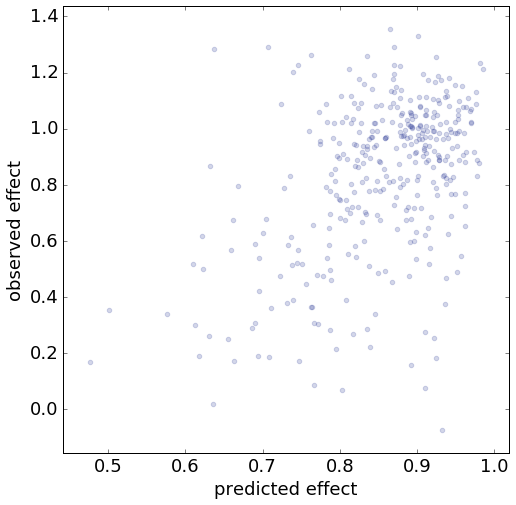

In [31]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('predicted effect')
ax.set_ylabel('observed effect')
ax.set_ylim([0,1.6])
ax.set_xlim([-0.2,1.6])
ax.scatter(pred,Yap65_data2['scaled_effect1'], alpha = 0.2, color = '#253494')
ax.axis('tight')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.show()

In [42]:
params = dict([('target', 'scaled_effect1'), ('max_depth', 5), ('max_iterations' , [10,25,50,100,250]), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , 1), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

In [72]:
params1 = dict([('target', 'scaled_effect1'), ('max_depth', [2, 6, 10, 25, 50] ), ('max_iterations' , 25), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , [2, 6, 10, 25, 50]), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

In [75]:
params2 = dict([('target', 'scaled_effect1'), ('max_depth',2), ('max_iterations' , 25), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' ,6 ), 
               ('min_loss_reduction' , [0, 0.1, 0.2, 0.3, 0.4, 0.5]), ('step_size' , 0.1), ('features' , [predictors3])])

In [78]:
params3 = dict([('target', 'scaled_effect1'), ('max_depth',2), ('max_iterations' , 25), 
               ('column_subsample' , [0.6, 0.7, 0.8, 0.9]), ('row_subsample' , [0.6, 0.7, 0.8, 0.9]), ('min_child_weight' ,6 ), 
               ('min_loss_reduction' ,  0), ('step_size' , 0.1), ('features' , [predictors3])])

In [79]:
NOhsp90_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['hsp90']], 'protein')
NOhsp90_data2 = NOhsp90_data.filter_by([x for x in NOhsp90_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOhsp90_data2['id']
NOhsp90_data2 = NOhsp90_data2.add_row_number('id',0)

folds = gl.cross_validation.KFold(NOhsp90_data2,10)

lopo_output_protein_hsp90 = gl.model_parameter_search.grid_search.create(folds, gl.boosted_trees_regression.create, params3)

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-10-2017-18-48-2300000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-10-2017-18-48-2300000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Aug-10-2017-18-48-2300000' already exists. Renaming the job to 'Model-Parameter-Search-Aug-10-2017-18-48-2300000-81f5b'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-10-2017-18-48-2300000-81f5b' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-10-2017-18-48-2300000-81f5b' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-10-2017-18-48-2300001' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-10-2017-18-48

In [80]:
lopo_output_protein_hsp90.get_best_params()

{'column_subsample': 0.9,
 'features': ['aa1',
  'aa2',
  'wt_mut',
  'aa1_polarity',
  'aa2_polarity',
  'aa1_PI',
  'aa2_PI',
  'deltaPI',
  'Grantham',
  'aa1_weight',
  'aa2_weight',
  'deltaWeight',
  'aa1vol',
  'aa2vol',
  'deltavolume',
  'aa1_psic',
  'aa2_psic',
  'delta_psic',
  'accessibility',
  'dssp_sec_str',
  'phi_psi_reg',
  'delta_solvent_accessibility',
  'b_factor',
  'mut_msa_congruency',
  'mut_mut_msa_congruency',
  'seq_ind_closest_mut',
  'evolutionary_coupling_avg'],
 'max_depth': 2,
 'max_iterations': 25,
 'min_child_weight': 6,
 'min_loss_reduction': 0,
 'row_subsample': 0.8,
 'step_size': 0.1,
 'target': 'scaled_effect1'}

In [81]:
## hsp90
Nohsp90_model = gl.boosted_trees_regression.create(NOhsp90_data2, 'scaled_effect1', features = predictors3, max_iterations = 250,
                                                   column_subsample = 0.9, row_subsample = 0.8,
                                                           min_child_weight = 6, min_loss_reduction =0.9, step_size = 0.01, max_depth = 2)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees regression:

--------------------------------------------------------

Number of examples          : 23278

Number of features          : 27

Number of unpacked features : 27

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 0.032174     | 1.164069           | 1.057528             | 0.420901      | 0.420164        |

| 2         | 0.054345     | 1.160823           | 1.053110             | 0.418591      | 0.417911        |

| 3         | 0.073762     | 1.157913           | 1.050200             | 0.416360      | 0.415736        |

| 4         | 0.094596     | 1.154734           | 1.045885             | 0.414121      | 0.413555        |

| 5         | 0.113638     | 1.150842           | 1.041993             | 0.411937      | 0.411430        |

| 6         | 0.133656     | 1.146978           | 1.038129             | 0.409774      | 0.409326        |

| 11        | 0.228332     | 1.129865           | 1.019892             | 0.399423      | 0.399240        |

| 50        | 0.968378     | 1.031564           | 1.016978             | 0.339740      | 0.342125        |

| 51        | 0.988293     | 1.030010           | 1.018533             | 0.338646      | 0.341112        |

| 100       | 1.915019     | 1.094940           | 1.089094             | 0.299419      | 0.304214        |

| 101       | 1.934863     | 1.097104           | 1.090471             | 0.298895      | 0.303738        |

| 150       | 2.866823     | 1.148034           | 1.139012             | 0.279987      | 0.286242        |

| 200       | 3.814049     | 1.187919           | 1.173366             | 0.270286      | 0.277230        |

| 250       | 4.778492     | 1.212423           | 1.195994             | 0.264805      | 0.272266        |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

In [188]:
pickler = gl._gl_pickle.GLPickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/Nohsp90_model_regressionModel_noSELCO_limited_2017-02-08')
pickler.dump(Nohsp90_model)
pickler.close()

In [31]:
unpickler = gl._gl_pickle.GLUnpickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/Nohsp90_model_regressionModel_noSELCO_limited_2017-02-08')
Nohsp90_model = unpickler.load()
unpickler.close()

In [83]:
## hsp90
hsp90_data = data2.filter_by([x for x in data2['protein'].unique() if x in ['hsp90']], 'protein')
hsp90_data2 = hsp90_data.filter_by([x for x in hsp90_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del hsp90_data2['id']
hsp90_data2 = hsp90_data2.add_row_number('id',0)

pred = Nohsp90_model.predict(hsp90_data2)
stats.pearsonr(pred, hsp90_data2['scaled_effect1'])
#stats.spearmanr(pred, hsp90_data2['scaled_effect1'])
#sqrt(mean_squared_error(pred,hsp90_data2['scaled_effect1']))

(0.31738319252282299, 8.6586241575286882e-95)

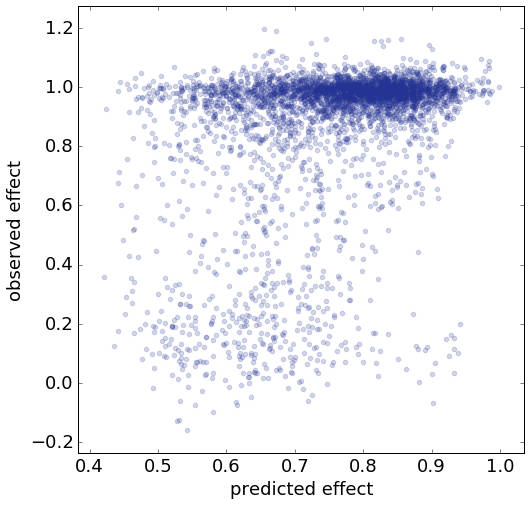

In [35]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('predicted effect')
ax.set_ylabel('observed effect')
ax.set_ylim([0,1.6])
ax.set_xlim([-0.2,1.6])
ax.scatter(pred,hsp90_data2['scaled_effect1'], alpha = 0.2, color = '#253494')
ax.axis('tight')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.show()

In [84]:
params = dict([('target', 'scaled_effect1'), ('max_depth', 5), ('max_iterations' , [10,25,50,100,250]), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , 1), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

In [5]:
params1 = dict([('target', 'scaled_effect1'), ('max_depth', [2, 6, 10, 25, 50] ), ('max_iterations' , 50), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , [2, 6, 10, 25, 50]), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

In [10]:
params2 = dict([('target', 'scaled_effect1'), ('max_depth',2), ('max_iterations' , 50), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' ,2 ), 
               ('min_loss_reduction' , [0, 0.1, 0.2, 0.3, 0.4, 0.5]), ('step_size' , 0.1), ('features' , [predictors3])])

In [17]:
params3 = dict([('target', 'scaled_effect1'), ('max_depth',2), ('max_iterations' , 50), 
               ('column_subsample' , [0.6, 0.7, 0.8, 0.9]), ('row_subsample' , [0.6, 0.7, 0.8, 0.9]), ('min_child_weight' ,2 ), 
               ('min_loss_reduction' ,  0.4), ('step_size' , 0.1), ('features' , [predictors3])])

In [6]:
NOgb1_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['gb1']], 'protein')
NOgb1_data2 = NOgb1_data.filter_by([x for x in NOgb1_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOgb1_data2['id']
NOgb1_data2 = NOgb1_data2.add_row_number('id',0)

folds = gl.cross_validation.KFold(NOgb1_data2,10)

In [18]:
lopo_output_protein_gb1 = gl.model_parameter_search.grid_search.create(folds, gl.boosted_trees_regression.create, params3)

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-11-2017-12-27-0500000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-11-2017-12-27-0500000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Aug-11-2017-12-27-0500000' already exists. Renaming the job to 'Model-Parameter-Search-Aug-11-2017-12-27-0500000-60221'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-11-2017-12-27-0500000-60221' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-11-2017-12-27-0500000-60221' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-11-2017-12-27-0500001' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-11-2017-12-27

In [19]:
lopo_output_protein_gb1.get_best_params()

{'column_subsample': 0.7,
 'features': ['aa1',
  'aa2',
  'wt_mut',
  'aa1_polarity',
  'aa2_polarity',
  'aa1_PI',
  'aa2_PI',
  'deltaPI',
  'Grantham',
  'aa1_weight',
  'aa2_weight',
  'deltaWeight',
  'aa1vol',
  'aa2vol',
  'deltavolume',
  'aa1_psic',
  'aa2_psic',
  'delta_psic',
  'accessibility',
  'dssp_sec_str',
  'phi_psi_reg',
  'delta_solvent_accessibility',
  'b_factor',
  'mut_msa_congruency',
  'mut_mut_msa_congruency',
  'seq_ind_closest_mut',
  'evolutionary_coupling_avg'],
 'max_depth': 2,
 'max_iterations': 50,
 'min_child_weight': 2,
 'min_loss_reduction': 0.4,
 'row_subsample': 0.9,
 'step_size': 0.1,
 'target': 'scaled_effect1'}

In [20]:
## gb1
Nogb1_model = gl.boosted_trees_regression.create(NOgb1_data2, 'scaled_effect1', features = predictors3, max_iterations = 250,
                                                   column_subsample = 0.7, row_subsample = 0.9,
                                                           min_child_weight = 2, min_loss_reduction = 0.4, step_size = 0.01, max_depth = 2)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees regression:

--------------------------------------------------------

Number of examples          : 26193

Number of features          : 27

Number of unpacked features : 27

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 0.021634     | 1.163968           | 0.936695             | 0.424529      | 0.417031        |

| 2         | 0.038813     | 1.159917           | 0.932644             | 0.422103      | 0.414670        |

| 3         | 0.057359     | 1.156105           | 0.928832             | 0.419748      | 0.412379        |

| 4         | 0.076860     | 1.152142           | 0.924868             | 0.417394      | 0.410089        |

| 5         | 0.096950     | 1.148234           | 0.920961             | 0.415080      | 0.407837        |

| 6         | 0.115415     | 1.144345           | 0.917071             | 0.412793      | 0.405615        |

| 11        | 0.207560     | 1.126054           | 0.901940             | 0.402125      | 0.395206        |

| 51        | 0.946578     | 1.034074           | 0.841517             | 0.338398      | 0.333398        |

| 100       | 1.849972     | 1.121521           | 0.766365             | 0.297621      | 0.294452        |

| 101       | 1.869958     | 1.122488           | 0.766992             | 0.297072      | 0.293933        |

| 200       | 3.685092     | 1.191112           | 0.855522             | 0.267497      | 0.266817        |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

In [164]:
pickler = gl._gl_pickle.GLPickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/Nogb1_model_regressionModel_noSELCO_limited_2017-02-08')
pickler.dump(Nogb1_model)
pickler.close()

In [33]:
unpickler = gl._gl_pickle.GLUnpickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/Nogb1_model_regressionModel_noSELCO_limited_2017-02-08')
Nogb1_model = unpickler.load()
unpickler.close()

In [22]:
## gb1
gb1_data = data2.filter_by([x for x in data2['protein'].unique() if x in ['gb1']], 'protein')
gb1_data2 = gb1_data.filter_by([x for x in gb1_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del gb1_data2['id']
gb1_data2 = gb1_data2.add_row_number('id',0)

pred = Nogb1_model.predict(gb1_data2)
stats.pearsonr(pred, gb1_data2['scaled_effect1'])
stats.spearmanr(pred, gb1_data2['scaled_effect1'])
#sqrt(mean_squared_error(pred,gb1_data2['scaled_effect1']))

SpearmanrResult(correlation=0.19447200110408999, pvalue=2.3023118762338498e-10)

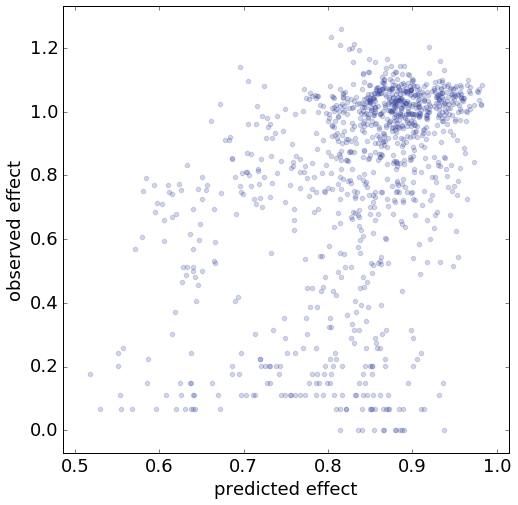

In [38]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('predicted effect')
ax.set_ylabel('observed effect')
ax.set_ylim([0,1.6])
ax.set_xlim([-0.2,1.6])
ax.scatter(pred,gb1_data2['scaled_effect1'], alpha = 0.2, color = '#253494')
ax.axis('tight')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.show()

In [50]:
data2['snap2score'] = data2['snap2score'].astype(int)

In [52]:
## SNAP PREDICTIONS
## ALL AA
data2.to_dataframe().groupby(['dms_id'])['scaled_effect1', 'snap2score'].corr()

scaled_effect1  snap2score
dms_id                                                   
Brca1_E3       scaled_effect1        1.000000         NaN
               snap2score                 NaN         NaN
Brca1_Y2H      scaled_effect1        1.000000         NaN
               snap2score                 NaN         NaN
E1_Ubiquitin   scaled_effect1        1.000000   -0.260187
               snap2score           -0.260187    1.000000
E3_ligase      scaled_effect1        1.000000         NaN
               snap2score                 NaN         NaN
PSD95pdz3      scaled_effect1        1.000000   -0.369989
               snap2score           -0.369989    1.000000
Pab1           scaled_effect1        1.000000   -0.473339
               snap2score           -0.473339    1.000000
Ubiquitin      scaled_effect1        1.000000   -0.331440
               snap2score           -0.331440    1.000000
WW_domain      scaled_effect1        1.000000   -0.449136
               snap2score           -0.449136    1.000000
beta-lactamase scaled_effect1        1.000000   -0.619270
               snap2score           -0.619270    1.000000
gb1            scaled_effect1        1.000000   -0.175484
               snap2score           -0.175484    1.000000
hsp90          scaled_effect1        1.000000   -0.435641
               snap2score           -0.435641    1.000000
kka2_1:2       scaled_effect1        1.000000   -0.647184
               snap2score           -0.647184    1.000000

In [53]:
data2.to_dataframe().groupby(['dms_id'])['scaled_effect1', 'snap2score'].corr(method = 'spearman')

scaled_effect1  snap2score
dms_id                                                   
Brca1_E3       scaled_effect1        1.000000         NaN
               snap2score                 NaN         NaN
Brca1_Y2H      scaled_effect1        1.000000         NaN
               snap2score                 NaN         NaN
E1_Ubiquitin   scaled_effect1        1.000000   -0.307250
               snap2score           -0.307250    1.000000
E3_ligase      scaled_effect1        1.000000         NaN
               snap2score                 NaN         NaN
PSD95pdz3      scaled_effect1        1.000000   -0.397588
               snap2score           -0.397588    1.000000
Pab1           scaled_effect1        1.000000   -0.553834
               snap2score           -0.553834    1.000000
Ubiquitin      scaled_effect1        1.000000   -0.381629
               snap2score           -0.381629    1.000000
WW_domain      scaled_effect1        1.000000   -0.474537
               snap2score           -0.474537    1.000000
beta-lactamase scaled_effect1        1.000000   -0.688730
               snap2score           -0.688730    1.000000
gb1            scaled_effect1        1.000000   -0.166484
               snap2score           -0.166484    1.000000
hsp90          scaled_effect1        1.000000   -0.443654
               snap2score           -0.443654    1.000000
kka2_1:2       scaled_effect1        1.000000   -0.638376
               snap2score           -0.638376    1.000000